Some $\LaTeX$ macros:

$$
\newcommand{\dd}{\mathrm{d}}
\newcommand{\diff}[2]{\frac{\dd #1}{\dd #2}}
$$

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
import pystan
import seaborn as sns
import scipy.special as sp

Populating the interactive namespace from numpy and matplotlib


In [2]:
sns.set_style('ticks')
sns.set_context('notebook')
sns.set_palette('colorblind')

Here is a more extensive example that illustrates fitting a the parameters of a Schechter galaxy luminosity function from a flux-limited galaxy survey.

The Luminosity function of galaxies is typically modelled by a Schechter function:
$$
\diff{N}{L} = \frac{\Lambda}{L_*^{1+\alpha} \Gamma\left(1+\alpha\right)} L^\alpha \exp\left[ - \frac{L}{L_*}\right]
$$
with $\alpha > -1$ and $L_*>0$ parameters controlling the shape of the distribution and $\Lambda$ the expected number of galaxies in the survey volume (i.e. the overall normalisation).

Suppose we can measure distances to galaxies perfectly, but that we typically measure fluxes (and therefore luminosities) with $\sigma_L \simeq 5\%$ uncertainty:
$$
p\left( L_\mathrm{obs} \mid L \right) = \frac{1}{\sigma_L L_\mathrm{obs} \sqrt{2\pi}} \exp\left[ - \frac{1}{2} \left(\frac{\log L - \log L_\mathrm{obs}}{\sigma_L} \right)^2\right].
$$

We want to use a flux-limited survey to infer the galaxy luminosity function.  Assume a Euclidean universe, so (in appropriate units)
$$
P_\mathrm{det} \left( L_\mathrm{obs} \right) = \begin{cases}
1 & \frac{L_\mathrm{obs}}{4 \pi z^2} > F_\mathrm{th} \\
0 & \mathrm{otherwise}
\end{cases}
$$
To make things a bit more efficient, we are going to assume that galaxies are distributed uniformly in $z$, rather than volumetrically (this will just reduce the number of low-flux galaxies we need to track in the integral, but dosen't fundamentally change the method).

We will assume that the true values of the parameters are $L_* = 1$, $\alpha = -0.5$, and choose a flux threshold so that we can just observe a $L_*$ galaxy at $z = 1$: $F_\mathrm{th} = \frac{1}{4\pi}$.  The code below draws random glaxies according to these recipes:

In [8]:
def schechter(L, alpha, Lstar):
    return L**alpha*exp(-L/Lstar)/(Lstar**(1+alpha)*sp.gamma(1+alpha))

In [9]:
def draw_redshift(zmax, size=1):
    return zmax*random.uniform(size=size)

In [10]:
def draw_luminosity(alpha, Lstar, size=1):
    xs = (1 - random.uniform(size=size))
    return Lstar*sp.gammaincinv(1+alpha, xs)

In [11]:
def draw_lobs(L, size=1):
    return exp(log(L) + 0.05*randn(size))

In [12]:
def draw_survey(N, alpha, Lstar, Fth, zmax):
    n = random.poisson(N)
    
    Ls = draw_luminosity(alpha, Lstar, size=n)
    zs = draw_redshift(zmax, size=n)
    
    Lobs = draw_lobs(Ls, size=n)
    
    Fobs = Lobs / (4*pi*zs*zs)
        
    sel = Fobs > Fth
    
    z99obs = percentile(zs[sel], 99)
    
    print(f'99th percentile of observed galaxy redshifts is {z99obs:.2f}')
    
    return Lobs[sel], sel.shape[0]-sum(sel)

Here we draw the observations of such a survey, and check that the highest-redshift observed galaxy is well within the maximum redshift that defines our survey volume.

In [105]:
Lambda_true = 100
alpha_true = -0.5
Lstar_true = 1.0
Fth = 1/(4*pi)
zmax = 2
Ls, NNobs = draw_survey(Lambda_true, alpha_true, Lstar_true, Fth, zmax)
print('Found {:d} galaxies and missed {:d} galaxies out to z = {:.1f}'.format(len(Ls), NNobs, zmax))

99th percentile of observed galaxy redshifts is 1.13
Found 24 galaxies and missed 80 galaxies out to z = 2.0


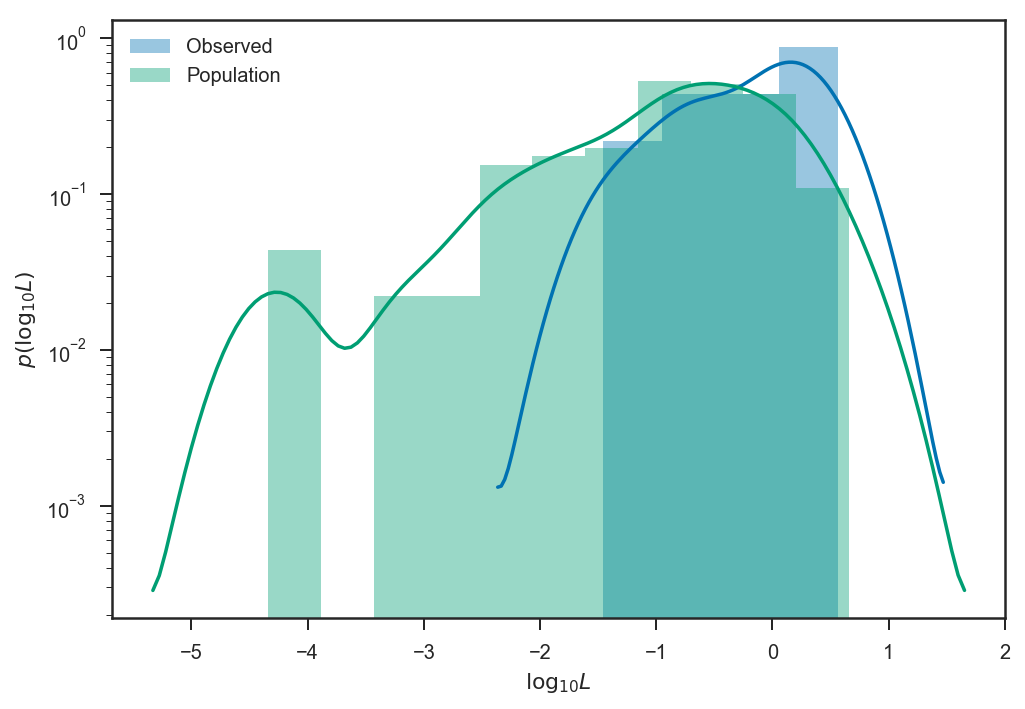

In [30]:
sns.distplot(log10(Ls), label="Observed")
sns.distplot(log10(draw_luminosity(-0.5, 1.0, size=100)), label='Population')
legend(loc='best')
yscale('log')
xlabel(r'$\log_{10} L$')
ylabel(r'$p\left( \log_{10} L\right)$')

The Stan model is in the file `schechter.stan`; the method is described in the accompanying `Gaussian.ipynb` notebook (we use the mixture-model formulation that proved most efficient in that test).  Note that, unlike for the Gaussian case, there is no analytic form for 
$$
\left\langle P_\mathrm{det} \right\rangle = \int \dd z \, \dd L \, \dd L_\mathrm{obs} \, P_\mathrm{det}\left(  \frac{L_\mathrm{obs}}{4\pi z^2} \right) p\left( L_\mathrm{obs} \mid L, z \right) p\left( L \mid \alpha, L_* \right) p\left(z \right),
$$
so we have to evaluate the fraction of the population that is detected numerically.

In [17]:
model = pystan.StanModel(file='schechter.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6de421e9172049b6fb9f19f5b9e9bc6e NOW.


As in `Gaussian.ipynb`, we choose to truncate the number of un-observed systems in the product in the likelihood at a number sufficient to encompass all the support for the number of *physical* non-observed systems; this is the `NNobs_max` parameter below.

In [87]:
fit = model.sampling(
    data = {'Nobs': len(Ls), 'Lobs': Ls, 'NNobs_max': 200, 'Funcert': 0.05, 'zmax': 2, 'Fth': 1.0/(4*pi)},
    iter = 4000,
    thin = 2)

In [88]:
fit

Inference for Stan model: anon_model_6de421e9172049b6fb9f19f5b9e9bc6e.
4 chains, each with iter=4000; warmup=2000; thin=2; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                  mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
Lambda           86.68     2.6  19.43  53.43  72.29  85.21  99.24 126.27     56   1.08
Lambda0          141.5    2.55  20.55 100.26 127.71 141.58 155.69 179.97     65   1.07
alpha             -0.4    0.02   0.22  -0.73  -0.57  -0.44  -0.27   0.11    125   1.03
Lstar             1.15    0.02   0.37   0.64   0.89   1.09   1.34   2.05    482   1.01
Ltrue[0]          0.91  8.9e-4   0.05   0.82   0.88   0.91   0.94   1.01   2658    1.0
Ltrue[1]          1.79  1.8e-3   0.09   1.62   1.73   1.78   1.84   1.97   2468    1.0
Ltrue[2]          1.53  1.4e-3   0.08   1.39   1.48   1.53   1.58   1.69   3131    1.0
Ltrue[3]          2.07  2.2e-3   0.11   1.87    2.0   2.07   2.14   2.29   2314    1.0
Ltrue[4]          1.05  9.6e

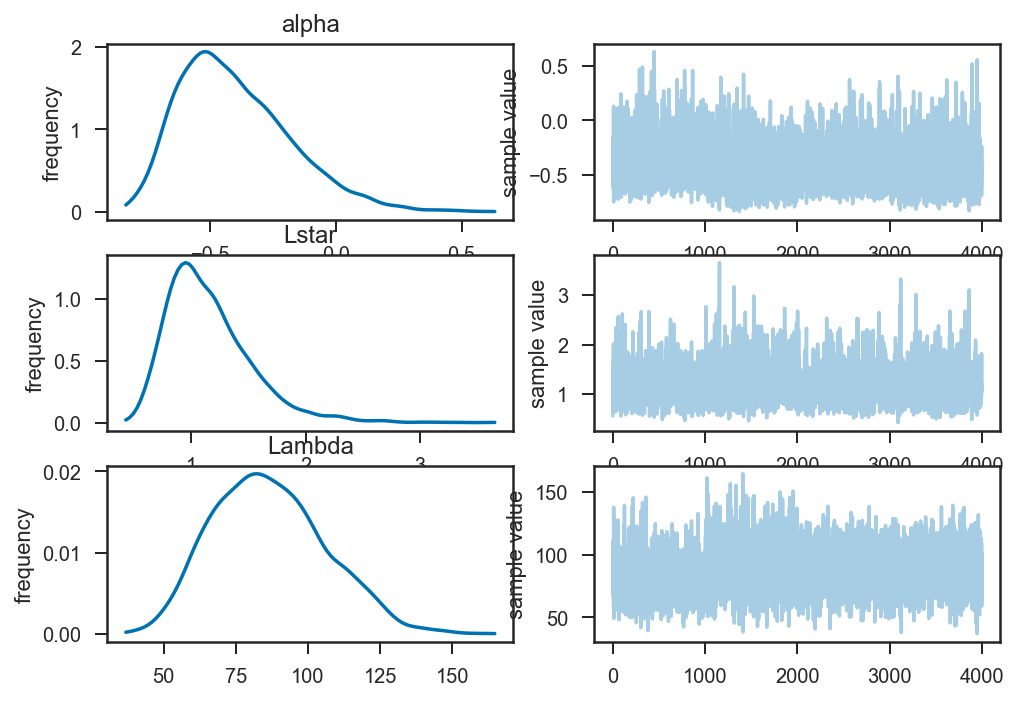

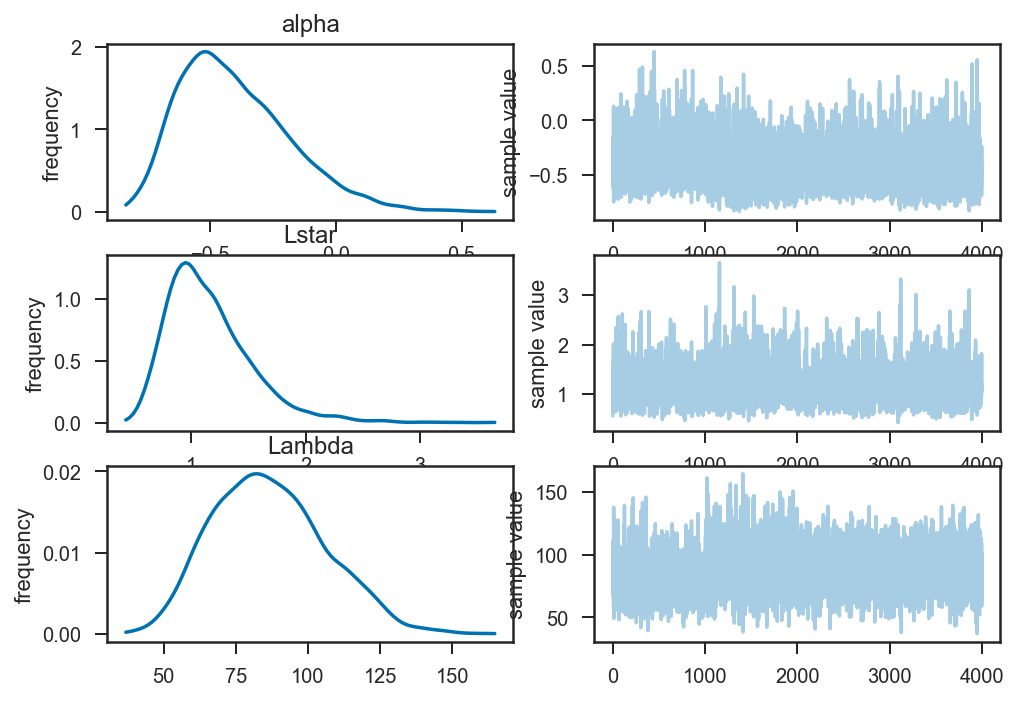

In [89]:
fit.plot(['alpha', 'Lstar', 'Lambda'])

In [90]:
chain = fit.extract(permuted=True)

Here come some 1-D marginals:

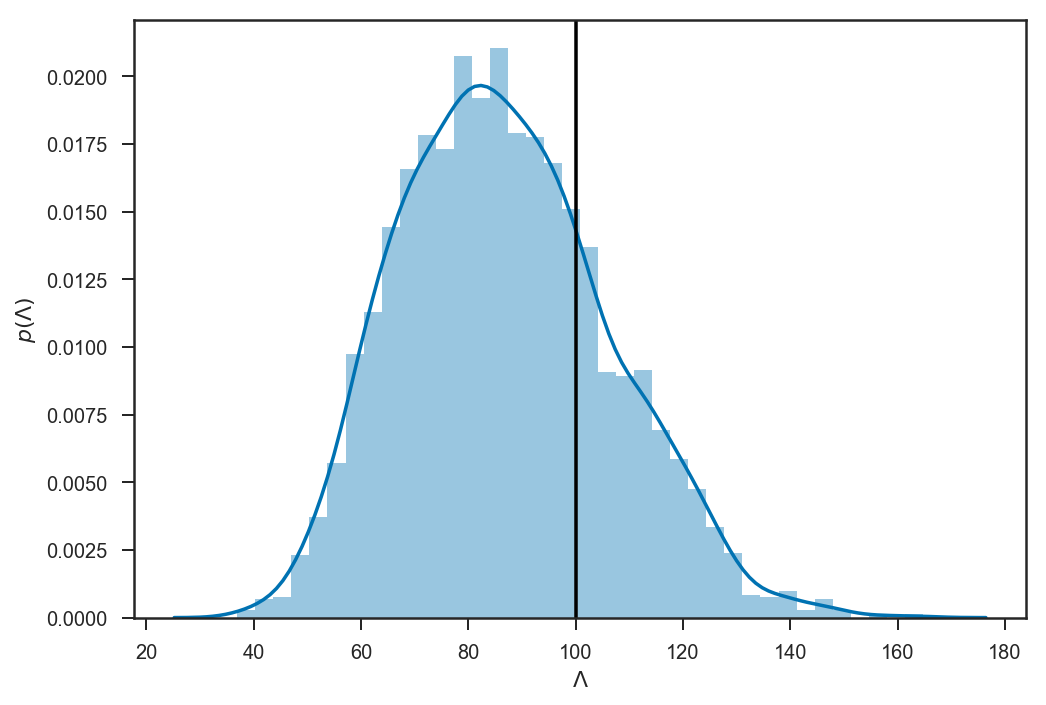

In [91]:
sns.distplot(chain['Lambda'])
axvline(Lambda_true, color='k')
xlabel(r'$\Lambda$')
ylabel(r'$p\left( \Lambda \right)$')

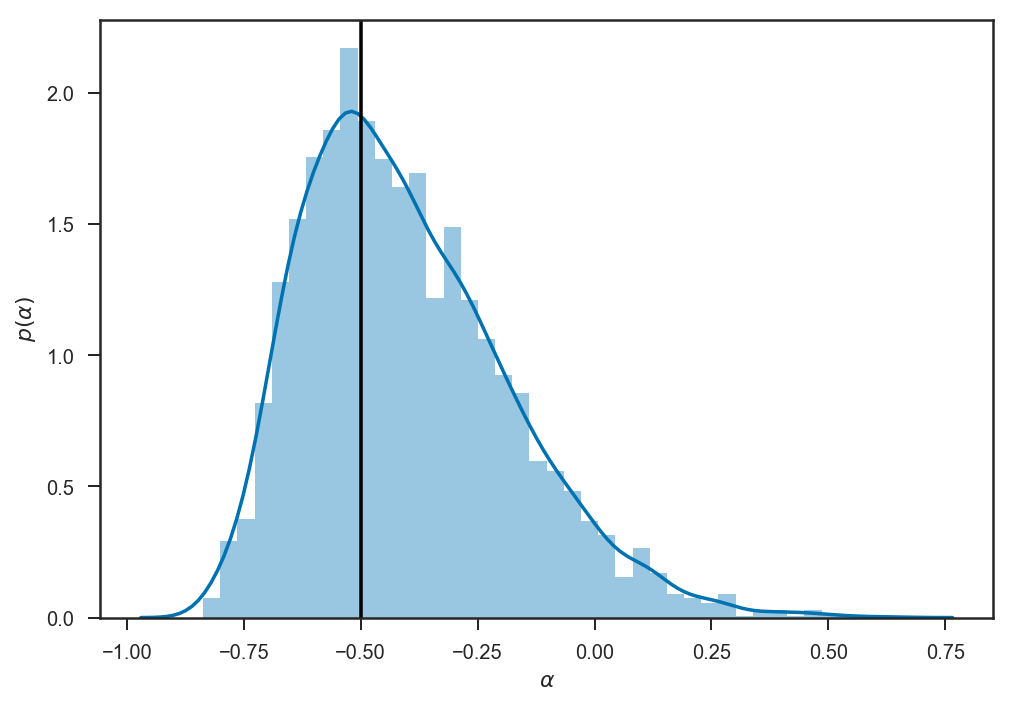

In [92]:
sns.distplot(chain['alpha'])
axvline(alpha_true, color='k')
xlabel(r'$\alpha$')
ylabel(r'$p\left( \alpha \right)$')

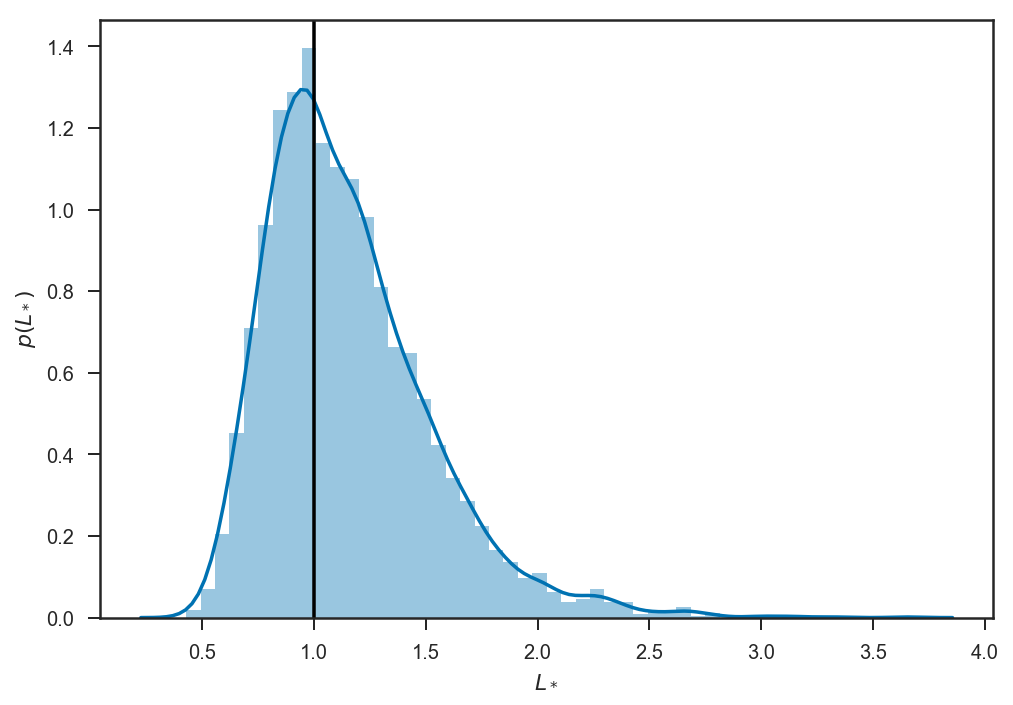

In [93]:
sns.distplot(chain['Lstar'])
axvline(Lstar_true, color='k')
xlabel(r'$L_*$')
ylabel(r'$p\left( L_* \right)$')

And the 2D posterior on the shape parameters for the galaxy luminosity function:

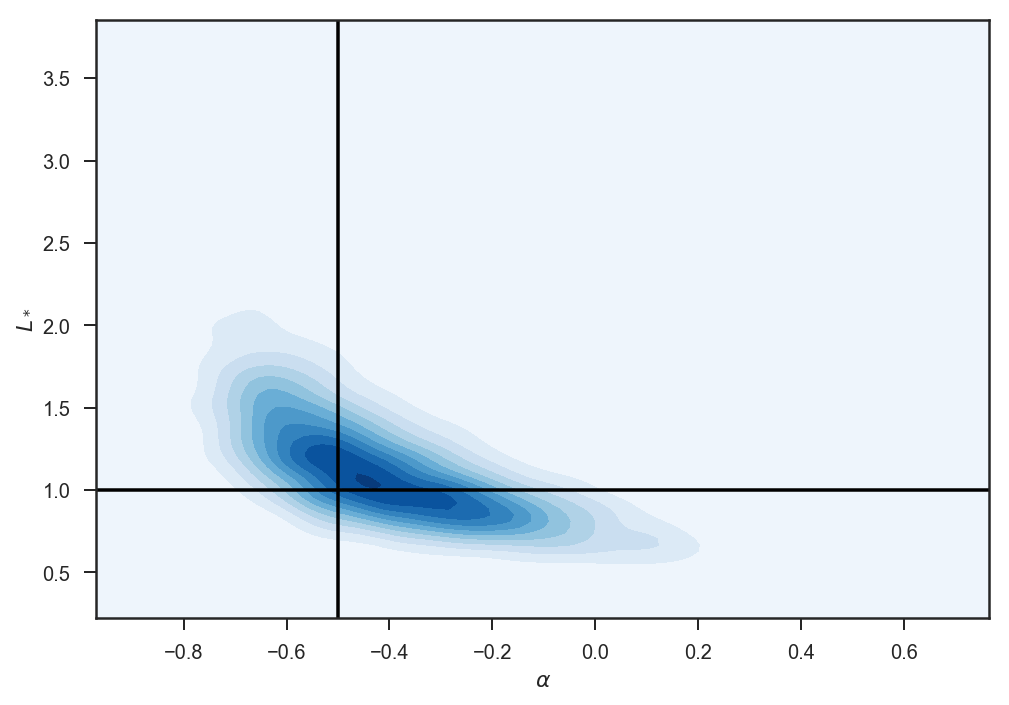

In [94]:
sns.kdeplot(chain['alpha'], chain['Lstar'], shade=True, cmap='Blues')
axvline(alpha_true, color='k')
axhline(Lstar_true, color='k')
xlabel(r'$\alpha$')
ylabel(r'$L_*$')

A pretty 1D plot of the inferred galaxy LF (grey) compared to the inverse-detection-efficiency-at-bin-centre-weighted histogram estimator.  Not bad!

In [115]:
Ls = Ls_obs

/Users/farr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


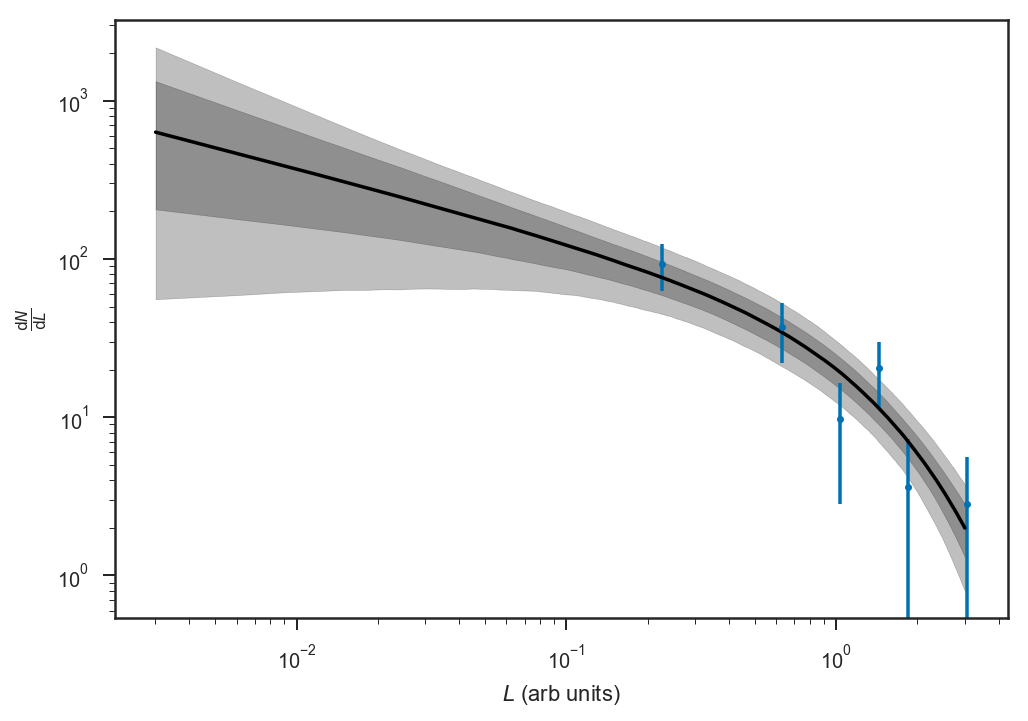

In [120]:
Ls_eval = linspace(0, 3, 1000)[1:]
LFs = []
for L, alpha, Lstar in zip(chain['Lambda'], chain['alpha'], chain['Lstar']):
    LFs.append(L*schechter(Ls_eval, alpha, Lstar))
LFs = array(LFs)
plot(Ls_eval, median(LFs, axis=0), color='k')
fill_between(Ls_eval, percentile(LFs, 84, axis=0), percentile(LFs, 16, axis=0), color='k', alpha=0.25)
fill_between(Ls_eval, percentile(LFs, 97.5, axis=0), percentile(LFs, 2.5, axis=0), color='k', alpha=0.25)

cts, bins = np.histogram(Ls, bins=8)
dndl = cts / diff(bins) / (sqrt(0.5*(bins[1:]+bins[:-1])/(4*pi*Fth))/zmax)

errorbar(0.5*(bins[1:]+bins[:-1]), dndl, dndl/sqrt(cts), fmt='.')

yscale('log')
xscale('log')
xlabel(r'$L$ (arb units)')
ylabel(r'$\frac{\mathrm{d}N}{\mathrm{d}L}$')

In [110]:
sum()

91.711171372137883

In [111]:
trapz(100*schechter(Ls, -0.5, 1.0), Ls)

92.515069588714738